In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import timeit
import scipy.fftpack
import scipy.io as sio
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import interpolate
from PIL import Image
from skimage import filters
import scipy.ndimage as ndimage
import scipy
import imageio

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

"""
6.819 Advances in Computer Vision
Bill Freeman, Antonio Torralba

Final Project - Optical Music Recognition Program
cadenCV
"""
__author__ = "Afika Nyati"
__email__ = "anyati@mit.edu"
__status__ = "Prototype"

# cv2.imshow("Input", no_staff_img)
# cv2.waitKey(0)

#-------------------------------------------------------------------------------
# Import Statements
#-------------------------------------------------------------------------------

import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from copy import deepcopy
from PIL import Image
from midiutil.MidiFile import MIDIFile

#from box import BoundingBox
#from primitive import Primitive
#from bar import Bar


In [3]:

#-------------------------------------------------------------------------------
# Template Paths
#-------------------------------------------------------------------------------


clef_paths = {
    "treble": [
        "resources/template/clef/treble_1.jpg",
        "resources/template/clef/treble_2.jpg"
    ],
    "bass": [
        "resources/template/clef/bass_1.jpg"
    ]
}

accidental_paths = {
    "sharp": [
        "resources/template/sharp-line.png",
        "resources/template/sharp-space.png"
    ],
    "flat": [
        "resources/template/flat-line.png",
        "resources/template/flat-space.png"
    ]
}

note_paths = {
    "quarter": [
        "resources/template/note/quarter.png",
        "resources/template/note/solid-note.png"
    ],
    "half": [
        "resources/template/note/half-space.png",
        "resources/template/note/half-note-line.png",
        "resources/template/note/half-line.png",
        "resources/template/note/half-note-space.png"
    ],
    "whole": [
        "resources/template/note/whole-space.png",
        "resources/template/note/whole-note-line.png",
        "resources/template/note/whole-line.png",
        "resources/template/note/whole-note-space.png"
    ]
}
rest_paths = {
    "eighth": ["resources/template/rest/eighth_rest.jpg"],
    "quarter": ["resources/template/rest/quarter_rest.jpg"],
    "half": ["resources/template/rest/half_rest_1.jpg",
            "resources/template/rest/half_rest_2.jpg"],
    "whole": ["resources/template/rest/whole_rest.jpg"]
}

flag_paths = ["resources/template/flag/eighth_flag_1.jpg",
                "resources/template/flag/eighth_flag_2.jpg",
                "resources/template/flag/eighth_flag_3.jpg",
                "resources/template/flag/eighth_flag_4.jpg",
                "resources/template/flag/eighth_flag_5.jpg",
                "resources/template/flag/eighth_flag_6.jpg"]

barline_paths = ["resources/template/barline/barline_1.jpg",
                 "resources/template/barline/barline_2.jpg",
                 "resources/template/barline/barline_3.jpg",
                 "resources/template/barline/barline_4.jpg"]

#-------------------------------------------------------------------------------
# Template Images
#-------------------------------------------------------------------------------

# Clefs
clef_imgs = {
    "treble": [cv2.imread(clef_file, 0) for clef_file in clef_paths["treble"]],
    "bass": [cv2.imread(clef_file, 0) for clef_file in clef_paths["bass"]]
}

# Time Signatures
time_imgs = {
    "common": [cv2.imread(time, 0) for time in ["resources/template/time/common.jpg"]],
    "44": [cv2.imread(time, 0) for time in ["resources/template/time/44.jpg"]],
    "34": [cv2.imread(time, 0) for time in ["resources/template/time/34.jpg"]],
    "24": [cv2.imread(time, 0) for time in ["resources/template/time/24.jpg"]],
    "68": [cv2.imread(time, 0) for time in ["resources/template/time/68.jpg"]]
}

# Accidentals
sharp_imgs = [cv2.imread(sharp_files, 0) for sharp_files in accidental_paths["sharp"]]
flat_imgs = [cv2.imread(flat_file, 0) for flat_file in accidental_paths["flat"]]

# Notes
quarter_note_imgs = [cv2.imread(quarter, 0) for quarter in note_paths["quarter"]]
half_note_imgs = [cv2.imread(half, 0) for half in note_paths["half"]]
whole_note_imgs = [cv2.imread(whole, 0) for whole in note_paths['whole']]

# Rests
eighth_rest_imgs = [cv2.imread(eighth, 0) for eighth in rest_paths["eighth"]]
quarter_rest_imgs = [cv2.imread(quarter, 0) for quarter in rest_paths["quarter"]]
half_rest_imgs = [cv2.imread(half, 0) for half in rest_paths["half"]]
whole_rest_imgs = [cv2.imread(whole, 0) for whole in rest_paths['whole']]

# Eighth Flag
eighth_flag_imgs = [cv2.imread(flag, 0) for flag in flag_paths]

# Bar line
bar_imgs = [cv2.imread(barline, 0) for barline in barline_paths]


#-------------------------------------------------------------------------------
# Template Thresholds
#-------------------------------------------------------------------------------

# Clefs
clef_lower, clef_upper, clef_thresh = 50, 150, 0.88

# Time
time_lower, time_upper, time_thresh = 50, 150, 0.85

# Accidentals
sharp_lower, sharp_upper, sharp_thresh = 50, 150, 0.70
flat_lower, flat_upper, flat_thresh = 50, 150, 0.77

# Notes
quarter_note_lower, quarter_note_upper, quarter_note_thresh = 50, 150, 0.70
half_note_lower, half_note_upper, half_note_thresh = 50, 150, 0.70
whole_note_lower, whole_note_upper, whole_note_thresh = 50, 150, 0.7011

# Rests
eighth_rest_lower, eighth_rest_upper, eighth_rest_thresh = 50, 150, 0.75 # Before was 0.7
quarter_rest_lower, quarter_rest_upper, quarter_rest_thresh = 50, 150, 0.70
half_rest_lower, half_rest_upper, half_rest_thresh = 50, 150, 0.80
whole_rest_lower, whole_rest_upper, whole_rest_thresh = 50, 150, 0.80

# Eighth Flag
eighth_flag_lower, eighth_flag_upper, eighth_flag_thresh = 50, 150, 0.8

# Bar line
bar_lower, bar_upper, bar_thresh = 50, 150, 0.85

In [4]:

#-------------------------------------------------------------------------------

# Mapping Functions
#-------------------------------------------------------------------------------

pitch_to_MIDI = {
    "C8": 108,
    "B7": 107,
    "Bb7": 106,
    "A#7": 106,
    "A7": 105,
    "Ab7": 104,
    "G#7": 104,
    "G7": 103,
    "Gb7": 102,
    "F#7": 102,
    "F7": 101,
    "E7": 100,
    "Eb7": 99,
    "D#7": 99,
    "D7": 98,
    "Db7": 97,
    "C#7": 97,
    "C7": 96,
    "B6": 95,
    "Bb6": 94,
    "A#6": 94,
    "A6": 93,
    "Ab6": 92,
    "G#6": 92,
    "G6": 91,
    "Gb6": 90,
    "F#6": 90,
    "F6": 89,
    "E6": 88,
    "Eb6": 87,
    "D#6": 87,
    "D6": 86,
    "Db6": 85,
    "C#6": 85,
    "C6": 84,
    "B5": 83,
    "Bb5": 82,
    "A#5": 82,
    "A5": 81,
    "Ab5": 80,
    "G#5": 80,
    "G5": 79,
    "Gb5": 78,
    "F#5": 78,
    "F5": 77,
    "E5": 76,
    "Eb5": 75,
    "D#5": 75,
    "D5": 74,
    "Db5": 73,
    "C#5": 73,
    "C5": 72,
    "B4": 71,
    "Bb4": 70,
    "A#4": 70,
    "A4": 69,
    "Ab4": 68,
    "G#4": 68,
    "G4": 67,
    "Gb4": 66,
    "F#4": 66,
    "F4": 65,
    "E4": 64,
    "Eb4": 63,
    "D#4": 63,
    "D4": 62,
    "Db4": 61,
    "C#4": 61,
    "C4": 60,
    "B3": 59,
    "Bb3": 58,
    "A#3": 58,
    "A3": 57,
    "Ab3": 56,
    "G#3": 56,
    "G3": 55,
    "Gb3": 54,
    "F#3": 54,
    "F3": 53,
    "E3": 52,
    "Eb3": 51,
    "D#3": 51,
    "D3": 50,
    "Db3": 49,
    "C#3": 49,
    "C3": 48,
    "B2": 47,
    "Bb2": 46,
    "A#2": 46,
    "A2": 45,
    "Ab2": 44,
    "G#2": 44,
    "G2": 43,
    "Gb2": 42,
    "F#2": 42,
    "F2": 41,
    "E2": 40,
    "Eb2": 39,
    "D#2": 39,
    "D2": 38,
    "Db2": 37,
    "C#2": 37,
    "C2": 36,
    "B1": 35,
    "Bb1": 34,
    "A#1": 34,
    "A1": 33,
    "Ab1": 32,
    "G#1": 32,
    "G1": 31,
    "Gb1": 30,
    "F#1": 30,
    "F1": 29,
    "E1": 28,
    "Eb1": 27,
    "D#1": 27,
    "D1": 26,
    "Db1": 25,
    "C#1": 25,
    "C1": 24,
    "B0": 23,
    "Bb0": 22,
    "A#0": 22,
    "A0": 21
}

MIDI_to_pitch = {
    108: "C8",
    107: "B7",
    106: "A#7",
    105: "A7",
    104: "G#7",
    103: "G7",
    102: "F#7",
    101: "F7",
    100: "E7",
    99: "D#7",
    98: "D7",
    97: "C#7",
    96: "C7",
    95: "B6",
    94: "A#6",
    93: "A6",
    92: "G#6",
    91: "G6",
    90: "F#6",
    89: "F6",
    88: "E6",
    87: "D#6",
    86: "D6",
    85: "C#6",
    84: "C6",
    83: "B5",
    82: "A#5",
    81: "A5",
    80: "G#5",
    79: "G5",
    78: "F#5",
    77: "F5",
    76: "E5",
    75: "D#5",
    74: "D5",
    73: "C#5",
    72: "C5",
    71: "B4",
    70: "A#4",
    69: "A4",
    68: "G#4",
    67: "G4",
    66: "F#4",
    65: "F4",
    64: "E4",
    63: "D#4",
    62: "D4",
    61: "C#4",
    60: "C4",
    59: "B3",
    58: "A#3",
    57: "A3",
    56: "G#3",
    55: "G3",
    54: "F#3",
    53: "F3",
    52: "E3",
    51: "D#3",
    50: "D3",
    49: "C#3",
    48: "C3",
    47: "B2",
    46: "A#2",
    45: "A2",
    44: "G#2",
    43: "G2",
    42: "F#2",
    41: "F2",
    40: "E2",
    39: "D#2",
    38: "D2",
    37: "C#2",
    36: "C2",
    35: "B1",
    34: "A#1",
    33: "A1",
    32: "G#1",
    31: "G1",
    30: "F#1",
    29: "F1",
    28: "E1",
    27: "D#1",
    26: "D1",
    25: "C#1",
    24: "C1",
    23: "B0",
    22: "A#0",
    21: "A0"
}

key_signature_changes = {
    "sharp": ["", "F", "FC", "FCG", "FCGD", "FCGDA", "FCGDAE", "FCGDAEB"],
    "flat": ["", "B", "BE", "BEA", "BEAD", "BEADG", "BEADGC", "BEADGCF"]
}


Matching function

In [25]:
def match(img, templates, start_percent, stop_percent, threshold):
    img_width, img_height = img.shape[::-1]
    best_location_count = -1
    best_locations = []
    best_scale = 1

    # plt.axis([0, 2, 0, 1])
    # plt.show(block=False)

    x = []
    y = []
    for scale in [i/100.0 for i in range(start_percent, stop_percent + 1, 3)]:
        locations = []
        location_count = 0

        for template in templates:
            print("template is ", template, template.shape)
            print("img is ", img, img.shape)
            
            
            if (scale*template.shape[0] > img.shape[0] or scale*template.shape[1] > img.shape[1]):
                pass
            else:
                template = cv2.resize(template, None,
                    fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC)
                print("rescaled template shape is ", template.shape)
                result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
                result = np.where(result >= threshold)
                location_count += len(result[0])
                locations += [result]

        # print("scale: {0}, hits: {1}".format(scale, location_count))
        x.append(location_count)
        y.append(scale)
        # plt.plot(y, x)
        # plt.pause(0.00001)
        if (location_count > best_location_count):
            best_location_count = location_count
            best_locations = locations
            best_scale = scale
            # plt.axis([0, 2, 0, best_location_count])
        elif (location_count < best_location_count):
            pass
    # plt.close()

    return best_locations, best_scale


In [26]:



def locate_templates(img, templates, start, stop, threshold):

    locations, scale = match(img, templates, start, stop, threshold)
    img_locations = []
    for i in range(len(templates)):
        w, h = templates[i].shape[::-1]
        w *= scale
        h *= scale
        img_locations.append([BoundingBox(pt[0], pt[1], w, h) for pt in zip(*locations[i][::-1])])
    return img_locations


def merge_boxes(boxes, threshold):
    filtered_boxes = []
    while len(boxes) > 0:
        r = boxes.pop(0)
        boxes.sort(key=lambda box: box.distance(r))
        merged = True
        while (merged):
            merged = False
            i = 0
            for _ in range(len(boxes)):
                if r.overlap(boxes[i]) > threshold or boxes[i].overlap(r) > threshold:
                    r = r.merge(boxes.pop(i))
                    merged = True
                elif boxes[i].distance(r) > r.w / 2 + boxes[i].w / 2:
                    break
                else:
                    i += 1
        filtered_boxes.append(r)
    return filtered_boxes


Matching function

List of staffs, for now just screenshots 

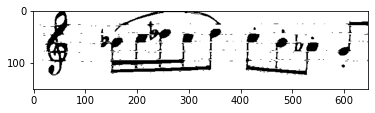

In [27]:
clean_sample = np.asarray(Image.open("./data/clean_sample.png"))
red = clean_sample[..., 0]
green = clean_sample[..., 1]
blue = clean_sample[..., 2]

clean_sample = 0.21 * red + 0.72 * green + 0.07 * blue
val = filters.threshold_otsu(clean_sample)
clean_sample[clean_sample > val] = 255
clean_sample[clean_sample <= val] =0

plt.imshow(clean_sample, cmap='gray')

In [28]:
staff_img = clean_sample

In [29]:
print(clef_imgs)

{'treble': [array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 253, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)], 'bass': [array([[208, 209, 205, ..., 208, 208, 208],
       [  5,   0,   4, ...,   0,   0,   0],
       [ 62,  65,  61, ...,  64,  64,  65],
       ...,
       [124, 124, 124, ..., 124, 124, 124],
       [  0,   0,   0, ...,   0,   0,   0],
       [149, 149, 149, ..., 149, 149, 149]], dtype=uint8)]}


In [30]:

# ------- Clef -------
for clef in clef_imgs:

    clef_boxes = locate_templates(staff_img, clef_imgs[clef], clef_lower, clef_upper, clef_thresh)
    clef_boxes = merge_boxes([j for i in clef_boxes for j in i], 0.5)

    if (len(clef_boxes) == 1):
        print("[INFO] Clef Found: ", clef)
        staffs[i].setClef(clef)

        # print("[INFO] Displaying Matching Results on staff", i + 1)
        clef_boxes_img = staffs[i].getImage()
        clef_boxes_img = clef_boxes_img.copy()

        for boxes in clef_boxes:
            boxes.draw(staff_img_color, red, box_thickness)
            x = int(boxes.getCorner()[0] + (boxes.getWidth() // 2))
            y = int(boxes.getCorner()[1] + boxes.getHeight() + 10)
            cv2.putText(staff_img_color, "{} clef".format(clef), (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.9, red)
        break


template is  [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]] (155, 60)
img is  [[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]] (151, 647)
rescaled template shape is  (78, 30)


error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/templmatch.cpp:1102: error: (-215:Assertion failed) (depth == 0 || depth == 5) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'


In [ ]:
#-------------------------------------------------------------------------------
# Symbol Segmentation, Object Recognition, and Semantic Reconstruction
#-------------------------------------------------------------------------------

# The score is then divided into regions of interest to localize and isolate the musical primitives.
# Music score is analyzed and split by staves
# Primitive symbols extracted

# Find all primitives on each stave first
# then move from left to right and create structure

# ============ Determine Clef, Time Signature ============

staff_imgs_color = []

for i in len(staff_lst):
    red = (0, 0, 255)
    box_thickness = 2
    staff_img = staffs[i].getImage()
    staff_img_color = staff_img.copy()
    staff_img_color = cv2.cvtColor(staff_img_color, cv2.COLOR_GRAY2RGB)

    # ------- Clef -------
    for clef in clef_imgs:
        print("[INFO] Matching {} clef template on staff".format(clef), i + 1)
        clef_boxes = locate_templates(staff_img, clef_imgs[clef], clef_lower, clef_upper, clef_thresh)
        clef_boxes = merge_boxes([j for i in clef_boxes for j in i], 0.5)

        if (len(clef_boxes) == 1):
            print("[INFO] Clef Found: ", clef)
            staffs[i].setClef(clef)

            # print("[INFO] Displaying Matching Results on staff", i + 1)
            clef_boxes_img = staffs[i].getImage()
            clef_boxes_img = clef_boxes_img.copy()

            for boxes in clef_boxes:
                boxes.draw(staff_img_color, red, box_thickness)
                x = int(boxes.getCorner()[0] + (boxes.getWidth() // 2))
                y = int(boxes.getCorner()[1] + boxes.getHeight() + 10)
                cv2.putText(staff_img_color, "{} clef".format(clef), (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.9, red)
            break

    else:
        # A clef should always be found
        print("[INFO] No clef found on staff", i+1)

    # # ------- Time -------
    for time in time_imgs:
        print("[INFO] Matching {} time signature template on staff".format(time), i + 1)
        time_boxes = locate_templates(staff_img, time_imgs[time], time_lower, time_upper, time_thresh)
        time_boxes = merge_boxes([j for i in time_boxes for j in i], 0.5)

        if (len(time_boxes) == 1):
            print("[INFO] Time Signature Found: ", time)
            staffs[i].setTimeSignature(time)

            # print("[INFO] Displaying Matching Results on staff", i + 1)

            for boxes in time_boxes:
                boxes.draw(staff_img_color, red, box_thickness)
                x = int(boxes.getCorner()[0] - (boxes.getWidth() // 2))
                y = int(boxes.getCorner()[1] + boxes.getHeight() + 20)
                cv2.putText(staff_img_color, "{} time".format(time), (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.9, red)
            break

        elif (len(time_boxes) == 0 and i > 0):
            # Take time signature of previous staff
            previousTime = staffs[i-1].getTimeSignature()
            staffs[i].setTimeSignature(previousTime)
            print("[INFO] No time signature found on staff", i + 1, ". Using time signature from previous staff line: ", previousTime)
            break
    else:
        print("[INFO] No time signature available for staff", i + 1)

    staff_imgs_color.append(staff_img_color)

# ============ Find Primitives ============

# always assert that notes in a bar equal duration dictated by time signature
for i in range(len(staffs)):
    print("[INFO] Finding Primitives on Staff ", i+1)
    staff_primitives = []
    staff_img = staffs[i].getImage()
    staff_img_color = staff_imgs_color[i]
    red = (0, 0, 255)
    box_thickness = 2

    # ------- Find primitives on staff -------
    print("[INFO] Matching sharp accidental template...")
    sharp_boxes = locate_templates(staff_img, sharp_imgs, sharp_lower, sharp_upper, sharp_thresh)
    sharp_boxes = merge_boxes([j for i in sharp_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in sharp_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "sharp"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        sharp = Primitive("sharp", 0, box)
        staff_primitives.append(sharp)

    print("[INFO] Matching flat accidental template...")
    flat_boxes = locate_templates(staff_img, flat_imgs, flat_lower, flat_upper, flat_thresh)
    flat_boxes = merge_boxes([j for i in flat_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in flat_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "flat"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        flat = Primitive("flat", 0, box)
        staff_primitives.append(flat)

    print("[INFO] Matching quarter note template...")
    quarter_boxes = locate_templates(staff_img, quarter_note_imgs, quarter_note_lower, quarter_note_upper, quarter_note_thresh)
    quarter_boxes = merge_boxes([j for i in quarter_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in quarter_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1/4 note"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        pitch = staffs[i].getPitch(round(box.getCenter()[1]))
        quarter = Primitive("note", 1, box, pitch)
        staff_primitives.append(quarter)

    print("[INFO] Matching half note template...")
    half_boxes = locate_templates(staff_img, half_note_imgs, half_note_lower, half_note_upper, half_note_thresh)
    half_boxes = merge_boxes([j for i in half_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in half_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1/2 note"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        pitch = staffs[i].getPitch(round(box.getCenter()[1]))
        half = Primitive("note", 2, box, pitch)
        staff_primitives.append(half)

    print("[INFO] Matching whole note template...")
    whole_boxes = locate_templates(staff_img, whole_note_imgs, whole_note_lower, whole_note_upper, whole_note_thresh)
    whole_boxes = merge_boxes([j for i in whole_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in whole_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1 note"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        pitch = staffs[i].getPitch(round(box.getCenter()[1]))
        whole = Primitive("note", 4, box, pitch)
        staff_primitives.append(whole)

    print("[INFO] Matching eighth rest template...")
    eighth_boxes = locate_templates(staff_img, eighth_rest_imgs, eighth_rest_lower, eighth_rest_upper, eighth_rest_thresh)
    eighth_boxes = merge_boxes([j for i in eighth_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in eighth_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1/8 rest"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        eighth = Primitive("rest", 0.5, box)
        staff_primitives.append(eighth)

    print("[INFO] Matching quarter rest template...")
    quarter_boxes = locate_templates(staff_img, quarter_rest_imgs, quarter_rest_lower, quarter_rest_upper, quarter_rest_thresh)
    quarter_boxes = merge_boxes([j for i in quarter_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in quarter_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1/4 rest"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        quarter = Primitive("rest", 1, box)
        staff_primitives.append(quarter)

    print("[INFO] Matching half rest template...")
    half_boxes = locate_templates(staff_img, half_rest_imgs, half_rest_lower, half_rest_upper, half_rest_thresh)
    half_boxes = merge_boxes([j for i in half_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in half_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1/2 rest"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        half = Primitive("rest", 2, box)
        staff_primitives.append(half)

    print("[INFO] Matching whole rest template...")
    whole_boxes = locate_templates(staff_img, whole_rest_imgs, whole_rest_lower, whole_rest_upper, whole_rest_thresh)
    whole_boxes = merge_boxes([j for i in whole_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in whole_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1 rest"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        whole = Primitive("rest", 4, box)
        staff_primitives.append(whole)

    print("[INFO] Matching eighth flag template...")
    flag_boxes = locate_templates(staff_img, eighth_flag_imgs, eighth_flag_lower, eighth_flag_upper, eighth_flag_thresh)
    flag_boxes = merge_boxes([j for i in flag_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)

    for box in flag_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "1/8 flag"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        flag = Primitive("eighth_flag", 0, box)
        staff_primitives.append(flag)

    print("[INFO] Matching bar line template...")
    bar_boxes = locate_templates(staff_img, bar_imgs, bar_lower, bar_upper, bar_thresh)
    bar_boxes = merge_boxes([j for i in bar_boxes for j in i], 0.5)

    print("[INFO] Displaying Matching Results on staff", i + 1)
    for box in bar_boxes:
        box.draw(staff_img_color, red, box_thickness)
        text = "line"
        font = cv2.FONT_HERSHEY_DUPLEX
        textsize = cv2.getTextSize(text, font, fontScale=0.7, thickness=1)[0]
        x = int(box.getCorner()[0] - (textsize[0] // 2))
        y = int(box.getCorner()[1] + box.getHeight() + 20)
        cv2.putText(staff_img_color, text, (x, y), font, fontScale=0.7, color=red, thickness=1)
        line = Primitive("line", 0, box)
        staff_primitives.append(line)

    print("[INFO] Saving detected primitives in staff {} onto disk".format(i+1))
    cv2.imwrite("output/staff_{}_primitives.jpg".format(i+1), staff_img_color)
    # open_file("output/staff_{}_primitives.jpg".format(i+1))

    # ------- Sort primitives on staff from left to right -------

    staff_primitives.sort(key=lambda primitive: primitive.getBox().getCenter())

    print("[INFO] Staff primitives sorted in time")
    eighth_flag_indices = []
    for j in range(len(staff_primitives)):

        if (staff_primitives[j].getPrimitive() == "eighth_flag"):
            # Find all eighth flags
            eighth_flag_indices.append(j)

        if (staff_primitives[j].getPrimitive() == "note"):
            print(staff_primitives[j].getPitch(), end=", ")
        else:
            print(staff_primitives[j].getPrimitive(), end=", ")

    print("\n")

    # ------- Correct for eighth notes -------
    print("[INFO] Correcting for misclassified eighth notes")
    # Sort out eighth flags
    # Assign to closest note
    for j in eighth_flag_indices:

        distances = []
        distance = staff_primitives[j].getBox().distance(staff_primitives[j-1].getBox())
        distances.append(distance)
        if (j + 1 < len(staff_primitives)):
            distance = staff_primitives[j].getBox().distance(staff_primitives[j+1].getBox())
            distances.append(distance)

        if (distances[1] and distances[0] > distances[1]):
            staff_primitives[j+1].setDuration(0.5)
        else:
            staff_primitives[j-1].setDuration(0.5)

        print("[INFO] Primitive {} was a eighth note misclassified as a quarter note".format(j+1))
        del staff_primitives[j]

    # Correct for beamed eighth notes
    # If number of pixels in center row of two notes
    # greater than 5 * line_width, then notes are
    # beamed
    for j in range(len(staff_primitives)):
        if (j+1 < len(staff_primitives)
            and staff_primitives[j].getPrimitive() == "note"
            and staff_primitives[j+1].getPrimitive() == "note"
            and (staff_primitives[j].getDuration() == 1 or staff_primitives[j].getDuration() == 0.5)
            and staff_primitives[j+1].getDuration() == 1):

            # Notes of interest
            note_1_center_x = staff_primitives[j].getBox().getCenter()[0]
            note_2_center_x = staff_primitives[j+1].getBox().getCenter()[0]

            # Regular number of black pixels in staff column
            num_black_pixels = 5 * staffs[i].getLineWidth()

            # Actual number of black pixels in mid column
            center_column = (note_2_center_x - note_1_center_x) // 2
            mid_col = staff_img[:, int(note_1_center_x + center_column)]
            num_black_pixels_mid = len(np.where(mid_col == 0)[0])

            if (num_black_pixels_mid > num_black_pixels):
                # Notes beamed
                # Make eighth note length
                staff_primitives[j].setDuration(0.5)
                staff_primitives[j+1].setDuration(0.5)
                print("[INFO] Primitive {} and {} were eighth notes misclassified as quarter notes".format(j+1, j+2))

    # ------- Account for Key Signature -------
    print("[INFO] Applying key signature note value changes")
    num_sharps = 0
    num_flats = 0
    j = 0
    while (staff_primitives[j].getDuration() == 0):
        accidental = staff_primitives[j].getPrimitive()
        if (accidental == "sharp"):
            num_sharps += 1
            j += 1

        elif (accidental == "flat"):
            num_flats += 1
            j += 1

    # Check if last accidental belongs to note

    if (j != 0):
        # Determine if accidental coupled with first note
        # Center of accidental should be within a note width from note
        max_accidental_offset_x = staff_primitives[j].getBox().getCenter()[0] - staff_primitives[j].getBox().getWidth()
        accidental_center_x = staff_primitives[j-1].getBox().getCenter()[0]
        accidental_type = staff_primitives[j-1].getPrimitive()

        if (accidental_center_x > max_accidental_offset_x):
            print("[INFO] Last accidental belongs to first note")
            num_sharps = num_sharps - 1 if accidental_type == "sharp" else num_sharps
            num_flats = num_flats - 1 if accidental_type == "flat" else num_flats

        # Modify notes in staff
        notes_to_modify = []
        if (accidental_type == "sharp"):
            print("[INFO] Key signature has {} sharp accidentals: ".format(num_sharps))
            notes_to_modify = key_signature_changes[accidental_type][num_sharps]
            # Remove accidentals from primitive list
            staff_primitives = staff_primitives[num_sharps:]
        else:
            print("[INFO] Key signature has {} flat accidentals: ".format(num_flats))
            notes_to_modify = key_signature_changes[accidental_type][num_flats]
            # Remove accidentals from primitive list
            staff_primitives = staff_primitives[num_flats:]

        print("[INFO] Corrected note values after key signature: ")
        for primitive in staff_primitives:
            type = primitive.getPrimitive()
            note = primitive.getPitch()
            if (type == "note" and note[0] in notes_to_modify):
                new_note = MIDI_to_pitch[pitch_to_MIDI[note] + 1] if accidental_type == "sharp" else MIDI_to_pitch[pitch_to_MIDI[note] - 1]
                primitive.setPitch(new_note)

            if (primitive.getPrimitive() == "note"):
                print(primitive.getPitch(), end=", ")
            else:
                print(primitive.getPrimitive(), end=", ")

        print("\n")

    # ------- Apply Sharps and Flats -------
    print("[INFO] Applying any accidental to neighboring note")
    primitive_indices_to_remove = []
    for j in range(len(staff_primitives)):
        accidental_type = staff_primitives[j].getPrimitive()

        if (accidental_type == "flat" or accidental_type == "sharp"):
            max_accidental_offset_x = staff_primitives[j+1].getBox().getCenter()[0] - staff_primitives[j+1].getBox().getWidth()
            accidental_center_x = staff_primitives[j].getBox().getCenter()[0]
            primitive_type = staff_primitives[j+1].getPrimitive()

            if (accidental_center_x > max_accidental_offset_x and primitive_type == "note"):
                print("Primitive has accidental associated with it")
                note = staff_primitives[j+1].getPitch()
                new_note = MIDI_to_pitch[pitch_to_MIDI[note] + 1] if accidental_type == "sharp" else MIDI_to_pitch[pitch_to_MIDI[note] - 1]
                staff_primitives[j+1].setPitch(new_note)
                primitive_indices_to_remove.append(i)

    # Removed actioned accidentals
    for j in primitive_indices_to_remove:
        del staff_primitives[j]

    print("[INFO] Corrected note values after accidentals: ")
    for j in range(len(staff_primitives)):
        if (staff_primitives[j].getPrimitive() == "note"):
            print(staff_primitives[j].getPitch(), end=", ")
        else:
            print(staff_primitives[j].getPrimitive(), end=", ")

    print("\n")


    # ------- Assemble Staff -------

    print("[INFO] Assembling current staff")
    bar = Bar()
    while (len(staff_primitives) > 0):
        primitive = staff_primitives.pop(0)

        if (primitive.getPrimitive() != "line"):
            bar.addPrimitive(primitive)
        else:
            staffs[i].addBar(bar)
            bar = Bar()
    # Add final bar in staff
    staffs[i].addBar(bar)

# -------------------------------------------------------------------------------
# Sequence MIDI
# -------------------------------------------------------------------------------

print("[INFO] Sequencing MIDI")
midi = MIDIFile(1)
track = 0
time = 0
channel = 0
volume = 100

midi.addTrackName(track, time, "Track")
midi.addTempo(track, time, 110)

for i in range(len(staffs)):
    print("==== Staff {} ====".format(i+1))
    bars = staffs[i].getBars()
    for j in range(len(bars)):
        print("--- Bar {} ---".format(j + 1))
        primitives = bars[j].getPrimitives()
        for k in range(len(primitives)):
            duration = primitives[k].getDuration()
            if (primitives[k].getPrimitive() == "note"):
                pitch = pitch_to_MIDI[primitives[k].getPitch()]
                midi.addNote(track, channel, pitch, time, duration, volume)
            print(primitives[k].getPrimitive())
            print(primitives[k].getPitch())
            print(primitives[k].getDuration())
            print("-----")
            time += duration

# ------- Write to disk -------
print("[INFO] Writing MIDI to disk")
binfile = open("output/output.mid", 'wb')
midi.writeFile(binfile)
binfile.close()










